In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from calibrated_response.models.variable import ContinuousVariable
from calibrated_response.models.query import (
    ProbabilityEstimate,
    ExpectationEstimate,
    ConditionalProbabilityEstimate,
    ConditionalExpectationEstimate,
    InequalityProposition,
)

In [2]:
# with open("maxent_llm_cache_large.pkl", "wb") as f:
#     import pickle
#     pickle.dump((variables, estimates), f)
with open("maxent_llm_cache_large.pkl", "rb") as f:
    import pickle
    variables, estimates = pickle.load(f)

In [3]:
from calibrated_response.energy_models.markov_random import MarkovRandomField
import jax.numpy as jnp

mrf = MarkovRandomField.from_estimates(variables, estimates, bins_per_var=5)
params_pytree = mrf.zero_params()
params = mrf.pack_params(params_pytree)
energy_fn = mrf.energy_fn_flat
# init_x = jnp.array([2.0, 1.0])  # Initial guess for (gdp_growth, inflation_rate)
init_x = jnp.zeros(len(variables))  # Initial guess at the mean of the distribution
energy_value = energy_fn(params, init_x)
print(f"Energy at initial guess: {energy_value}")

Energy at initial guess: 0.0


In [ ]:
from calibrated_response.maxent_smm.distribution_builder import DistributionBuilder
from calibrated_response.maxent_smm.maxent_solver import JAXSolverConfig

config = JAXSolverConfig(
    num_chains=512,
    num_iterations=500,
    mcmc_steps_per_iteration=4,
    learning_rate=0.002,

    l2_regularization=1e-2,

    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
    continuous_prior="gaussian",
)

builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config,
                              energy_fn=energy_fn, init_theta=params)

# Build for GDP growth (the solver trains once; marginals for all variables are in info)
distribution, info = builder.build(target_variable=variables[0].name)

print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")

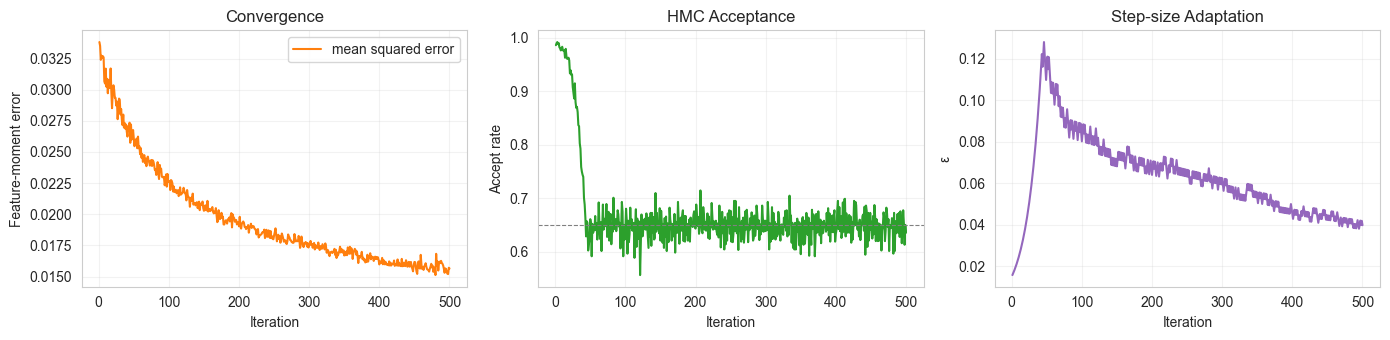

Final max error:  0.78666
Final mean error: 0.09143
Final accept rate: 0.636


In [23]:
history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

# axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
# axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].plot(history["iteration"], history["mean_squared_error"], label="mean squared error", color="C1")

axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [32]:
feature_means = builder.solver._batch_feature_fn(info['chain_states']).mean(axis=0)
feature_targets = builder.feature_targets
error = feature_means - jnp.array(feature_targets)

print("\nFeature means under the distribution:")
for i, feature in enumerate(estimates):
    feature_name = feature.to_query_estimate()
    print(f"  {feature_name}: {feature_means[i]:.4f}")
    print(f"    target: {feature_targets[i]:.4f}, error: {error[i]:.4f}")




Feature means under the distribution:
  P(ai_bubble_bursts_by_2030 = True) = 0.4: 0.4746
    target: 0.4000, error: 0.0746
  E[annual_ai_software_revenue] = 750000000000.0: 0.3687
    target: 0.3421, error: 0.0266
  P(agi_breakthrough_achieved = True) = 0.15: 0.5170
    target: 0.1500, error: 0.3670
  P(major_ai_safety_incident = True) = 0.35: 0.4681
    target: 0.3500, error: 0.1181
  E[annual_vc_investment_ai] = 300000000000.0: 0.2346
    target: 0.2632, error: -0.0285
  P(llm_performance_plateau = True) = 0.6: 0.4565
    target: 0.6000, error: -0.1435
  E[fortune500_ai_adoption_rate] = 65.0: 0.6063
    target: 0.5625, error: 0.0438
  E[market_cap_top_ai_companies] = 20000000000000.0: 0.4280
    target: 0.3333, error: 0.0947
  P(strict_ai_regulation_passed = True) = 0.7: 0.6167
    target: 0.7000, error: -0.0833
  E[training_cost_sota_model] = 1000000000.0: 0.2133
    target: 0.0180, error: 0.1953
  E[ai_job_displacement_rate] = 5.0: 0.3696
    target: 0.1837, error: 0.1859
  P(majo

In [24]:
energy_model = info["energy_model"]
samples = energy_model.sample(n_samples=2000)

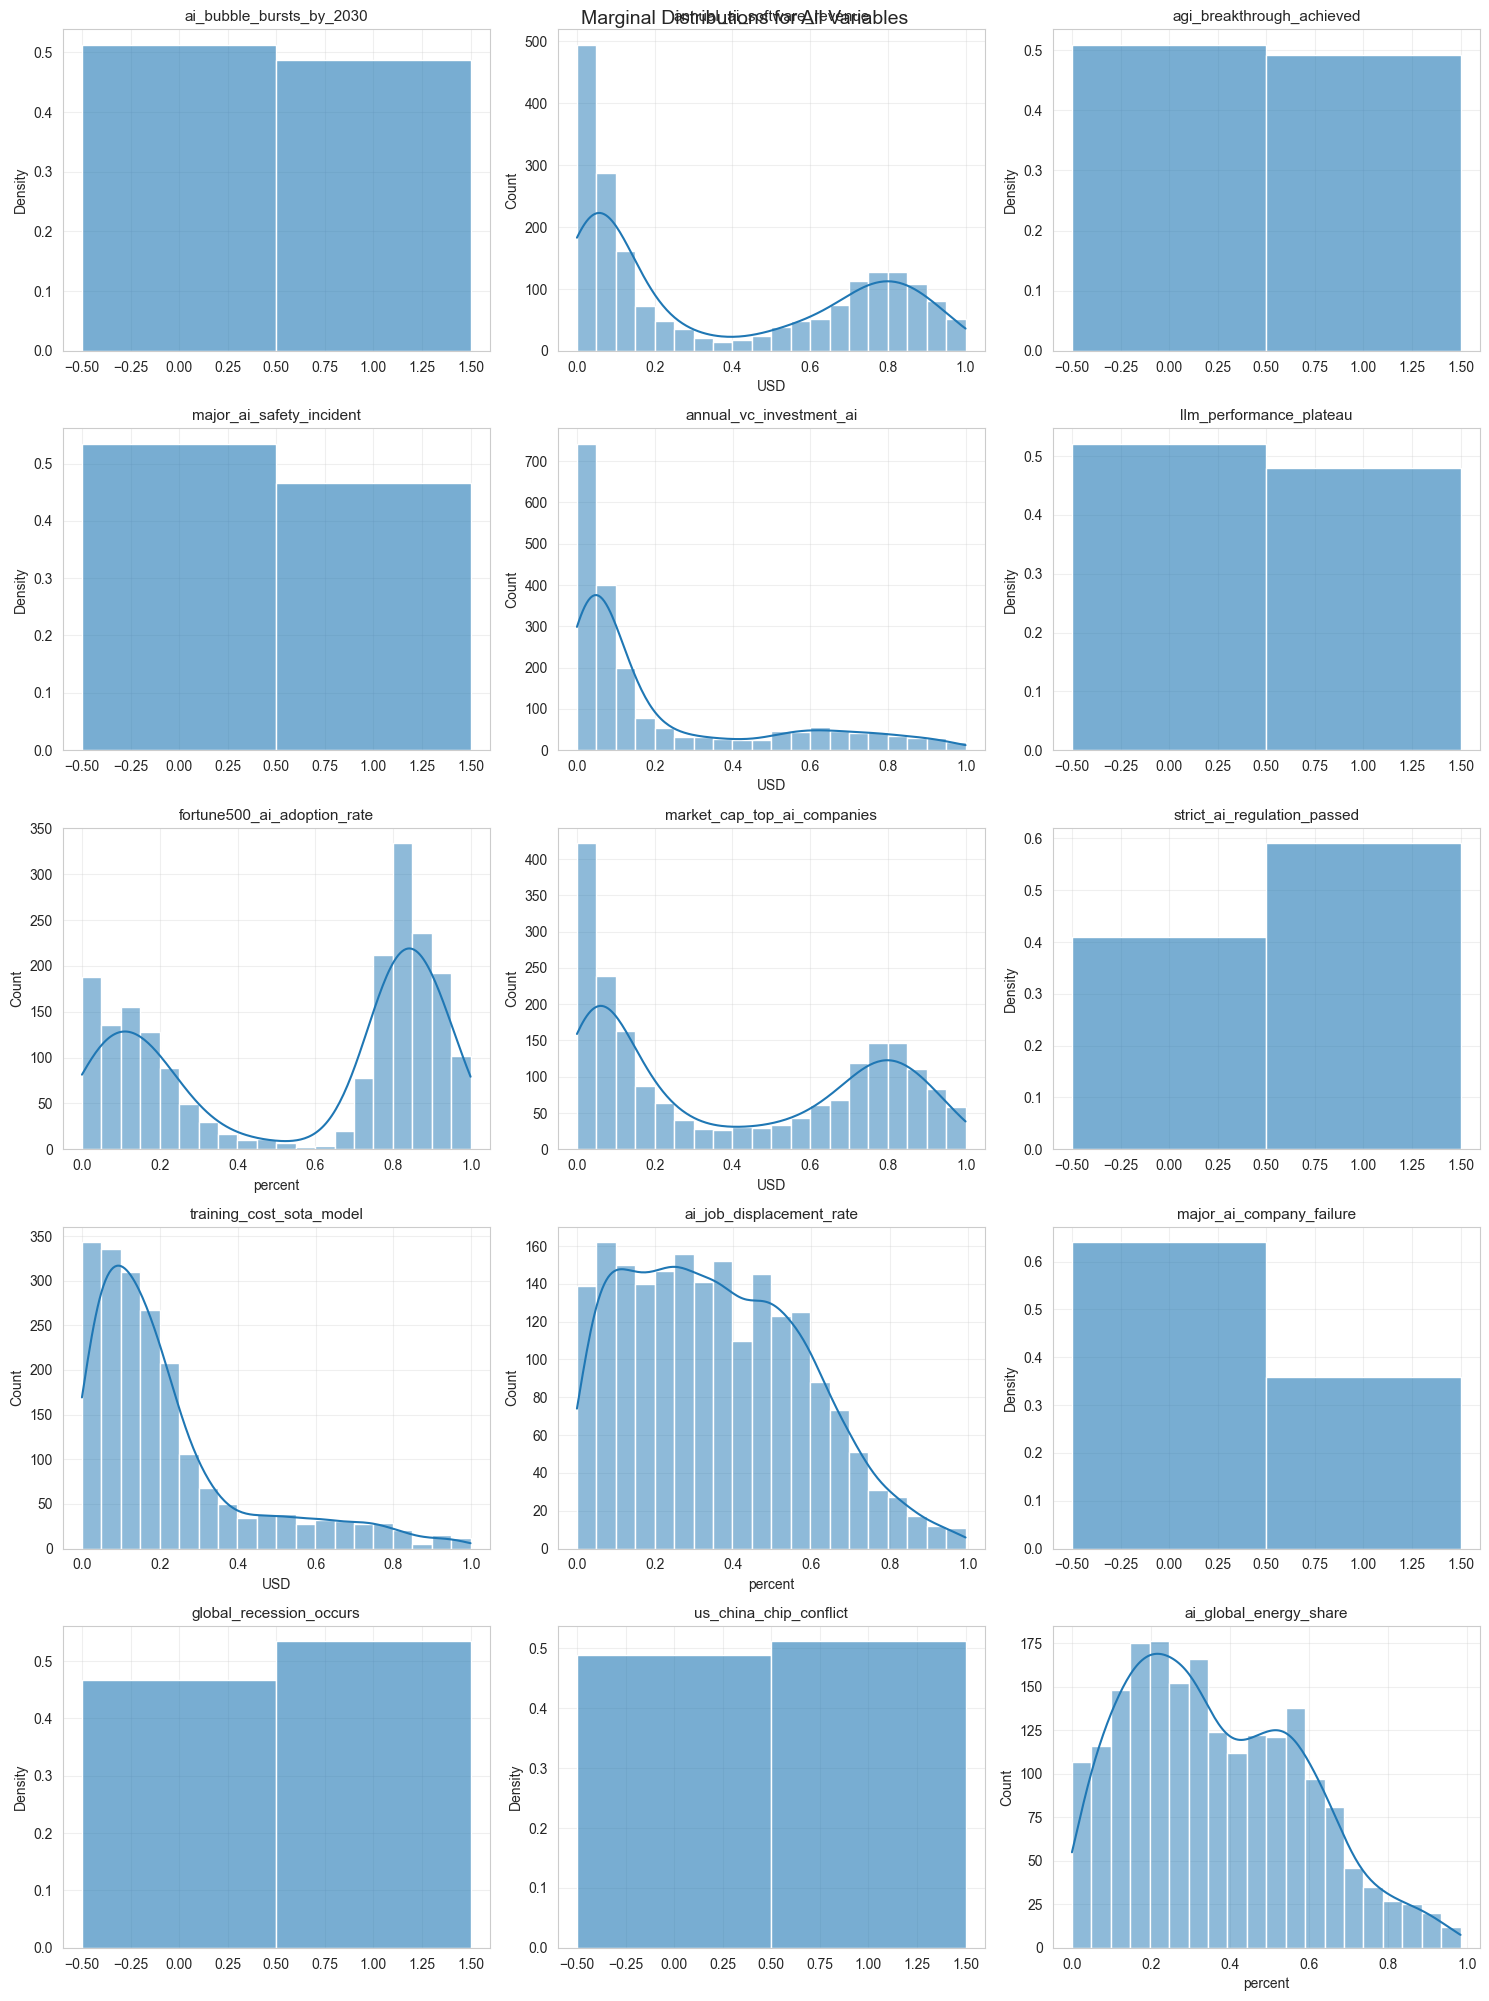

In [25]:
import seaborn as sns
from calibrated_response.models.variable import VariableType

# Plot all marginals in a grid
n_vars = len(variables)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()
    
for idx, var in enumerate(variables):
    if variables[idx].type == VariableType.BINARY:
        sns.histplot(samples[:, idx], bins=[-0.5, 0.5, 1.5], ax=axes[idx], color="C0", alpha=0.6, stat="density")
        # axes[idx].set_xticks([0, 1])
        # axes[idx].set_xticklabels(["False", "True"])
        # axes[idx].hist(samples[:, idx], bins=[-0.5, 0.5, 1.5], color="C0", alpha=0.6, density=True)
    else:
        sns.histplot(samples[:, idx], bins=20, kde=True, ax=axes[idx], color="C0")
        
    axes[idx].set_title(var.name, fontsize=11)
    axes[idx].set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All Variables', fontsize=14)
plt.tight_layout()
plt.show()

In [26]:
import jax.numpy as jnp
for i, var in enumerate(variables):
    print(f"{i}: {var.name}: mean={jnp.mean(samples[:, i]):.3f}, std={jnp.std(samples[:, i]):.3f}")

0: ai_bubble_bursts_by_2030: mean=0.495, std=0.341
1: annual_ai_software_revenue: mean=0.377, std=0.351
2: agi_breakthrough_achieved: mean=0.504, std=0.271
3: major_ai_safety_incident: mean=0.495, std=0.273
4: annual_vc_investment_ai: mean=0.214, std=0.272
5: llm_performance_plateau: mean=0.492, std=0.260
6: fortune500_ai_adoption_rate: mean=0.557, std=0.356
7: market_cap_top_ai_companies: mean=0.405, std=0.348
8: strict_ai_regulation_passed: mean=0.565, std=0.276
9: training_cost_sota_model: mean=0.217, std=0.211
10: ai_job_displacement_rate: mean=0.355, std=0.224
11: major_ai_company_failure: mean=0.425, std=0.271
12: global_recession_occurs: mean=0.524, std=0.271
13: us_china_chip_conflict: mean=0.517, std=0.269
14: ai_global_energy_share: mean=0.364, std=0.222


Text(0.5, 1.0, 'Joint Distribution of ai_bubble_bursts_by_2030 and market_cap_top_ai_companies')

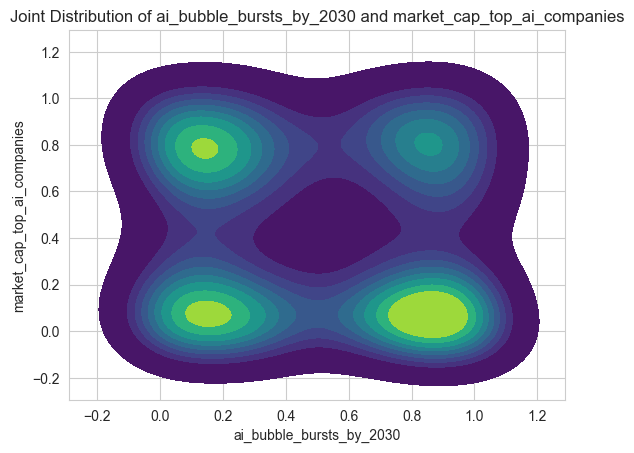

In [29]:
import seaborn as sns
sns.set_style("whitegrid")
# samples = samples[::5, :]
i1, i2 = 0, 7
sns.kdeplot(x=samples[:, i1], y=samples[:, i2], fill=True, thresh=0.01, cmap="viridis")
plt.xlabel(variables[i1].name)
plt.ylabel(variables[i2].name)
plt.title(f"Joint Distribution of {variables[i1].name} and {variables[i2].name}")